<a href="https://www.kaggle.com/code/aleksandrmorozov123/deep-learning-for-nlp?scriptVersionId=196408328" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/350000-jeopardy-questions/master_season1-35.tsv
/kaggle/input/350000-jeopardy-questions/kids_teen.tsv
/kaggle/input/lfwpeople/pairsDevTrain.txt
/kaggle/input/lfwpeople/lfw-funneled.tgz
/kaggle/input/lfwpeople/pairsDevTest.txt
/kaggle/input/lfwpeople/pairs.txt
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/analyst_ratings_processed.csv
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_analyst_ratings.csv
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_partner_headlines.csv


**Checking statistics of the Corpus**

In [2]:
# import required libraries
import pandas as pd

# we get first 10 000 values for fast running
ratings = pd.read_csv ('/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_analyst_ratings.csv')[0:10000]
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   headline    10000 non-null  object
 2   url         10000 non-null  object
 3   publisher   10000 non-null  object
 4   date        10000 non-null  object
 5   stock       10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [3]:
# comparing the text of two selected ratings
print (repr(ratings.iloc[3399]['headline'][0:300]))
print (repr(ratings.iloc[5487]['headline'][0:300]))

'Goldman Sachs Upgrades Alcoa To Buy, Raises Price Target (AA)'
"45 Stocks Moving In Thursday's Mid-Day Session"


In [4]:
# ignore spaces after the stop words
import re
ratings ["paragraphs"] = ratings ["headline"].map (lambda text: re.split ('[.?!]\s*\n', text))
ratings ['number_of_paragraphs'] = ratings ["paragraphs"].map (len)

**Preparations**

In [5]:
# import required libraries
import sklearn
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.de.stop_words import STOP_WORDS

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
vectors_text = tfidf_text_vectorizer.fit_transform (ratings ['headline'])
vectors_text.shape

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(10000, 10390)

In [6]:
# flatten the paragraphs keeping the sentiment
paragraph_df = pd.DataFrame ([{'headline': paragraph, 'publisher': publisher}
                             for paragraphs, publisher in \
                             zip (ratings ['paragraphs'], ratings ['publisher'])
                             for paragraph in paragraphs if paragraph])
tfidf_para_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform (paragraph_df ['headline'])
tfidf_para_vectors.shape

(10000, 10390)

**Nonnegative matrix factorization** - $ V \approx W \cdot H $

In [7]:
# import required library
from sklearn.decomposition import NMF

nmf_text_model = NMF (n_components = 10, random_state = 42)
W_text_matrix = nmf_text_model.fit_transform (vectors_text)
H_text_matrix = nmf_text_model.components_

# define a function for outputtin a summary
def display_topics (model, features, no_top_words=5):
    for topic, word_vector in enumerate (nmf_text_model.components_):
        total = word_vector.sum ()
        largest = word_vector.argsort ()[::-1]  # invert sort order
        print ("\ntopic %02d" % topic)
        for i in range (0, no_top_words):
            print ("  %s (%2.2f)" % (features [largest [i]],
                                    word_vector [largest[i]] * 100.0/total))
            
# calling the function
display_topics (nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


In [8]:
# normalizing topics
W_text_matrix.sum (axis=0)/W_text_matrix.sum()*100.0

array([11.13196912,  8.00564702, 11.05637611,  7.44085955, 12.66282551,
        7.01938348, 19.55898997,  6.65466007,  7.39061878,  9.07867037])

**Create a topic model for paragraphs using NMF**

In [9]:
nmf_para_model = NMF (n_components = 10, random_state = 42)
W_para_matrix = nmf_para_model.fit_transform (tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

display_topics (nmf_para_model, tfidf_para_vectorizer.get_feature_names_out ())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


**Latent semantic analysis with singular value decomposition** - any $ m \times n $ matrix V can be decomposed as follows
$V = U \cdot \Sigma \cdot V^* $

In [10]:
# import required module
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD (n_components = 10, random_state = 42)
W_svd_para_matrix = svd_para_model.fit_transform (tfidf_para_vectors)
H_svd_para_matrix = svd_para_model.components_

display_topics (svd_para_model, tfidf_para_vectorizer.get_feature_names_out ())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


**Latent Dirichlet Allocation**

In [11]:
# import required modules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

count_para_vectorizer = CountVectorizer (stop_words=list(STOP_WORDS))
count_para_vectors = count_para_vectorizer.fit_transform (paragraph_df ['headline'])

lda_para_model = LatentDirichletAllocation (n_components = 10, random_state = 42)
W_lda_para_matrix = lda_para_model.fit_transform (count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

display_topics (lda_para_model, tfidf_para_vectorizer.get_feature_names_out ())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


**Create Word Clouds to display and compare topic models**

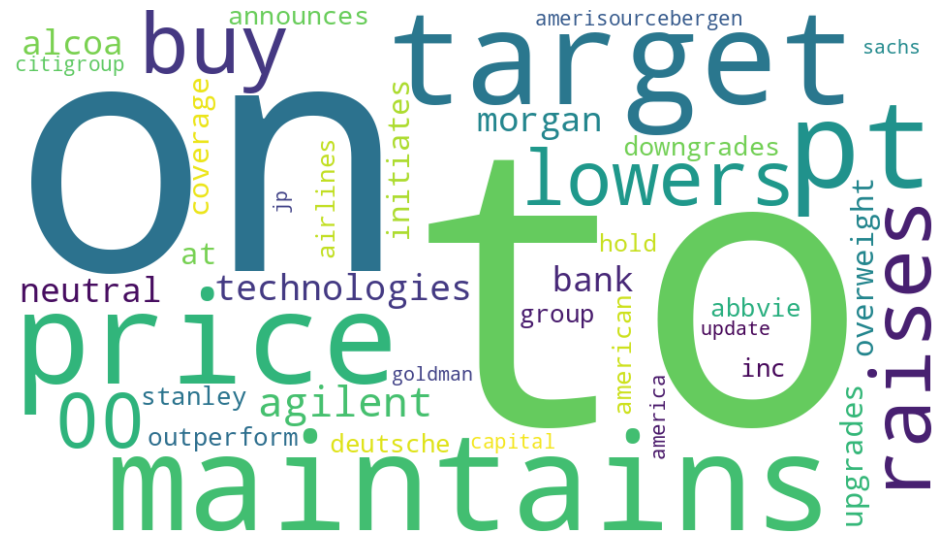

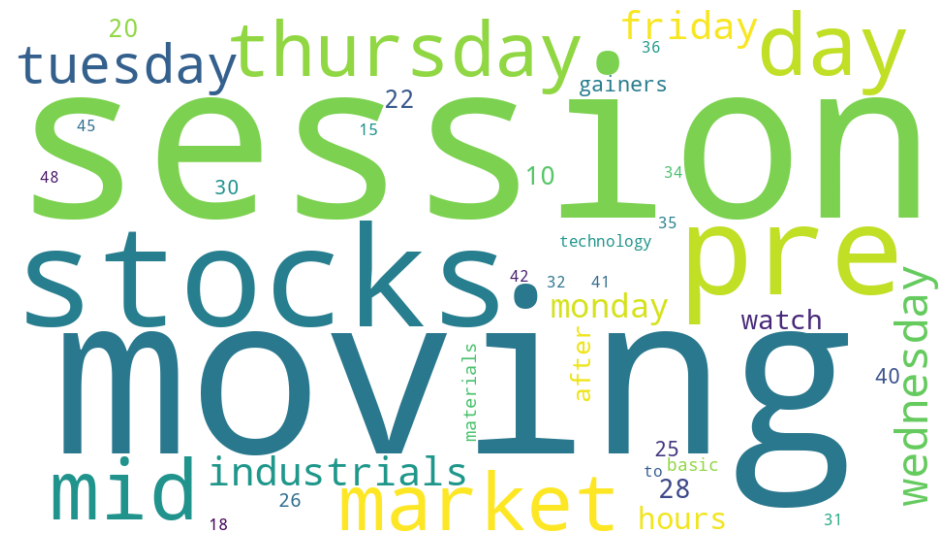

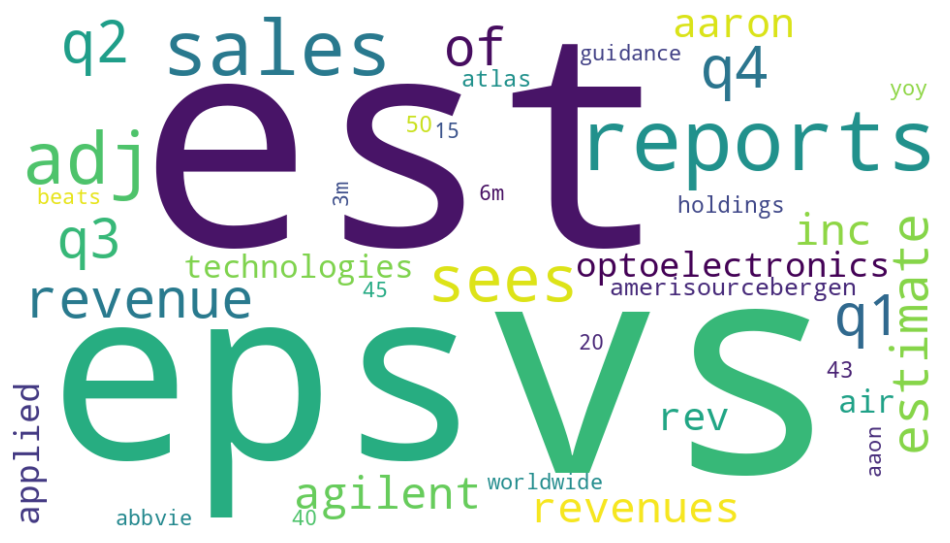

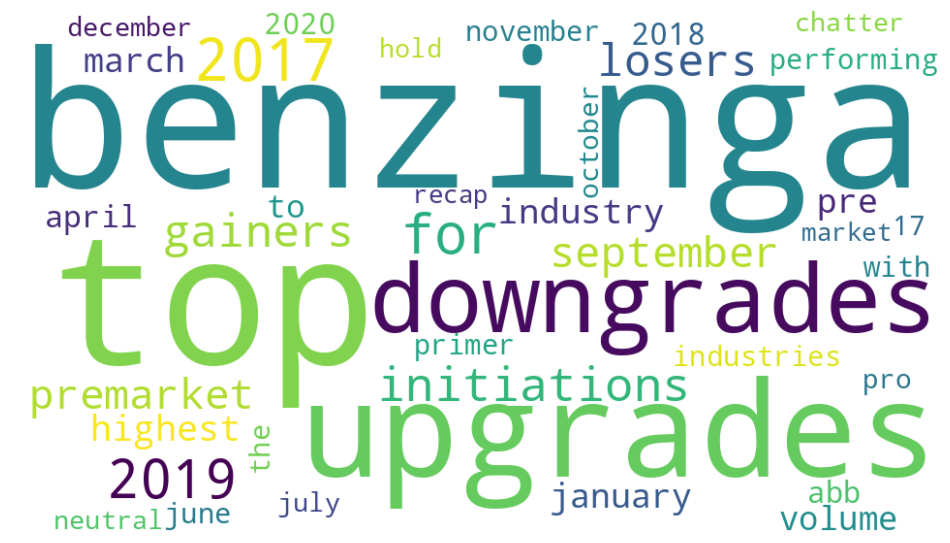

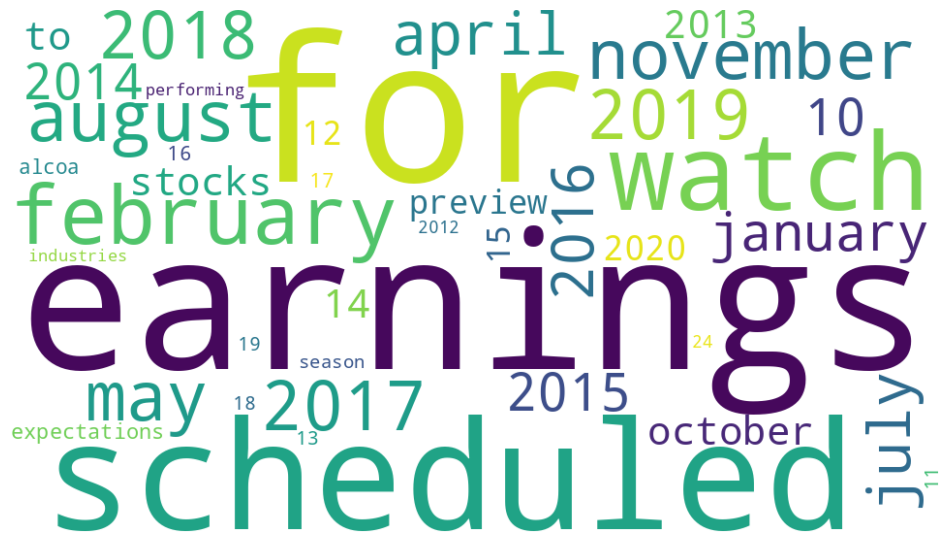

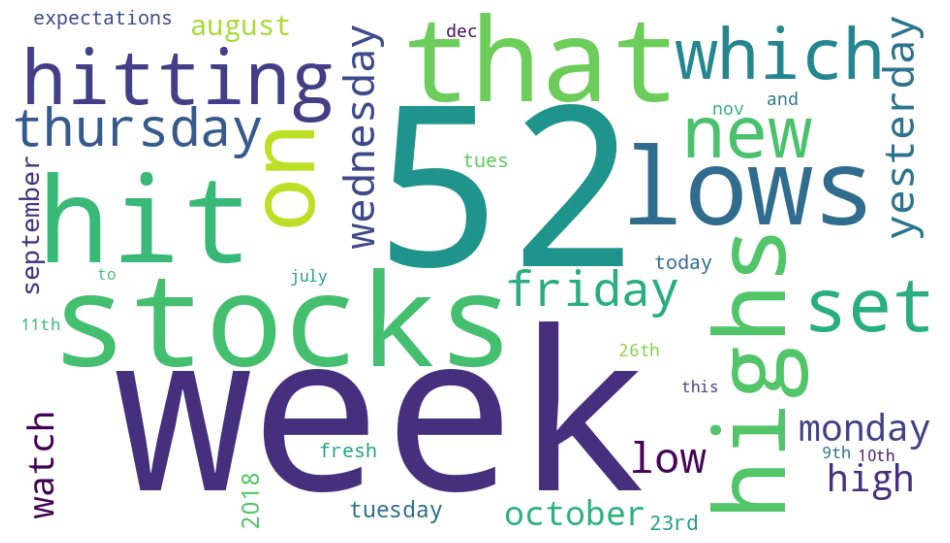

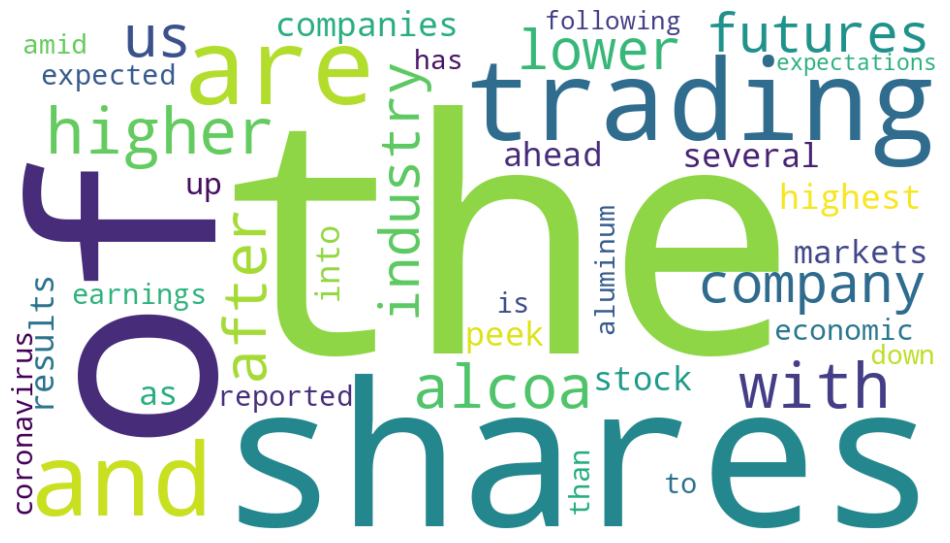

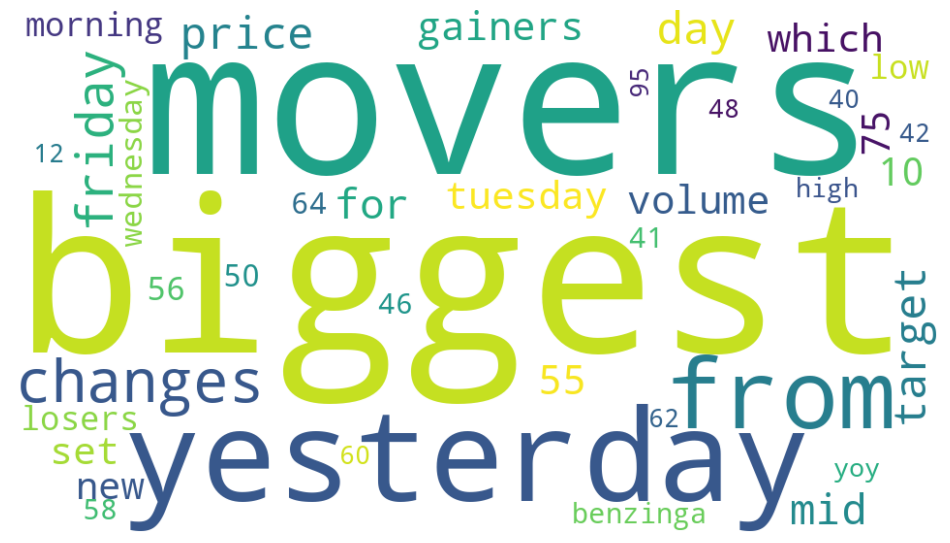

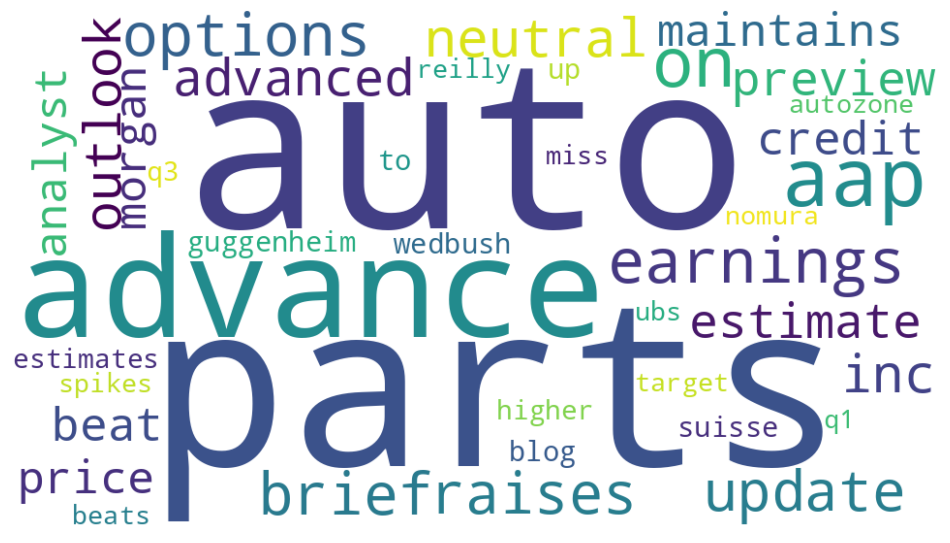

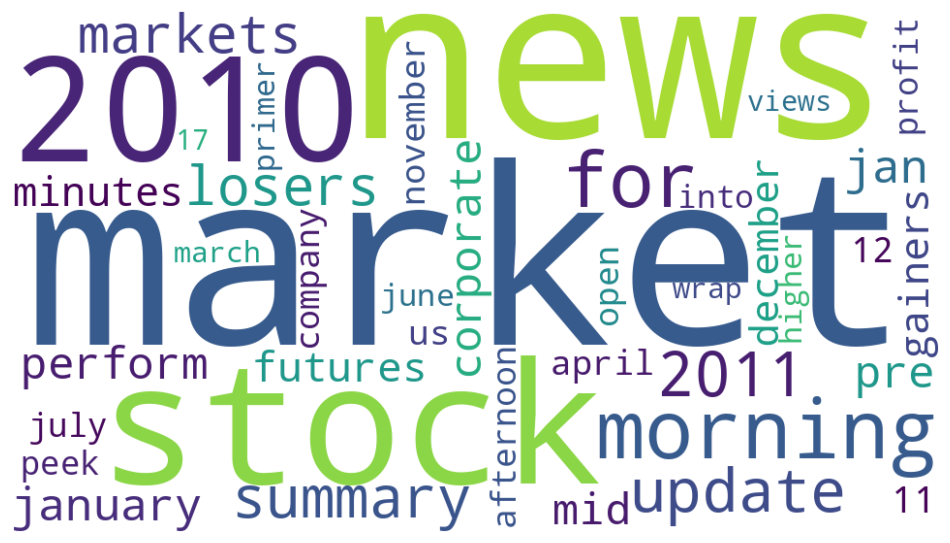

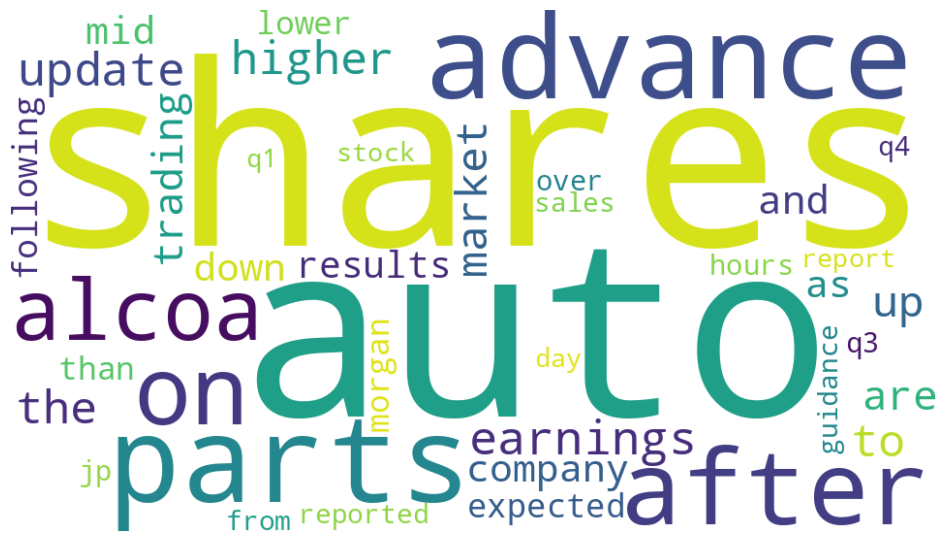

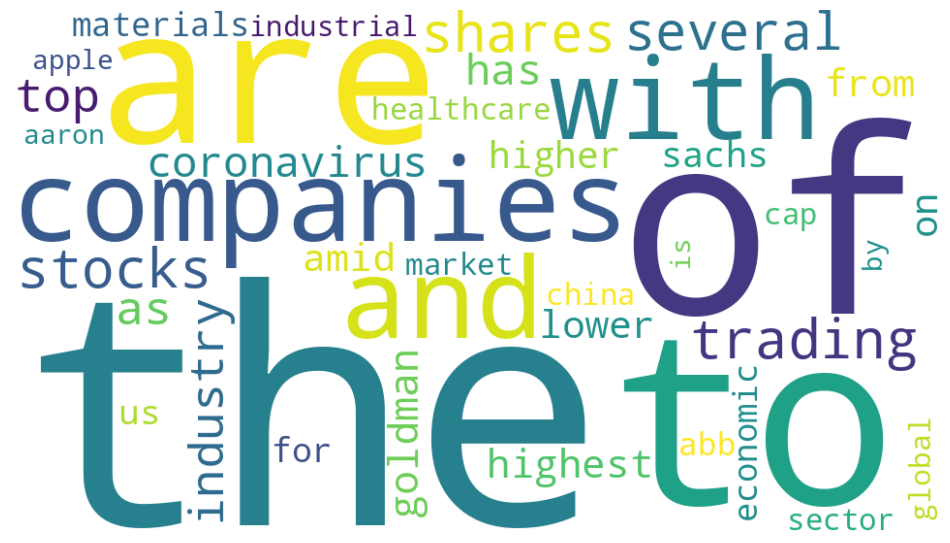

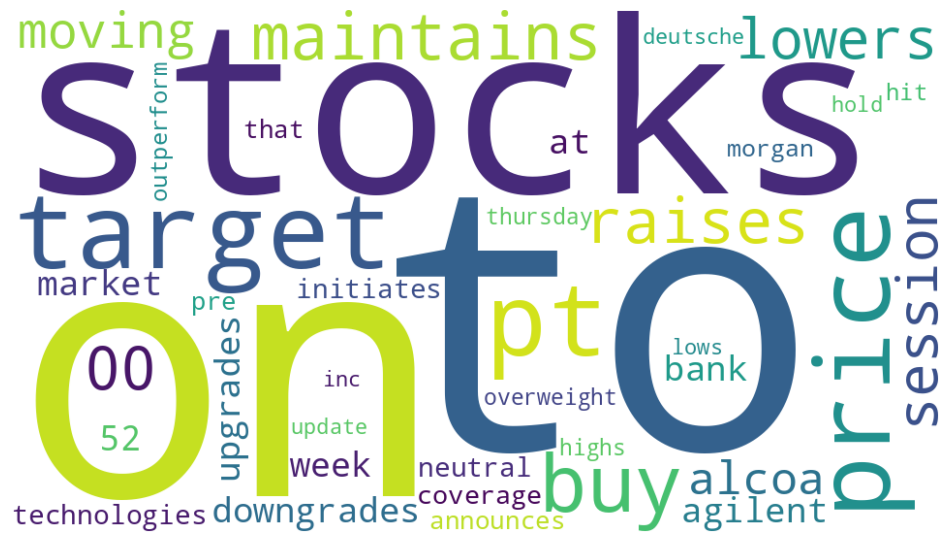

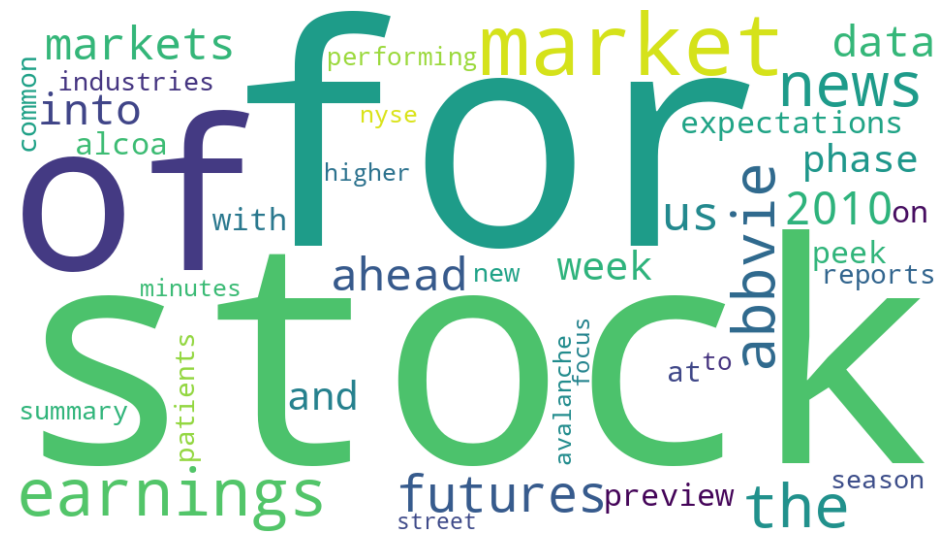

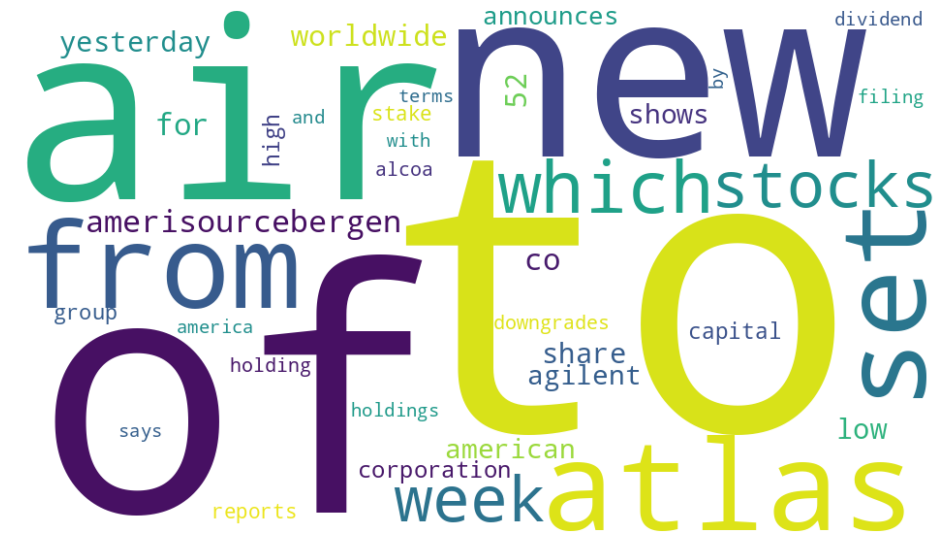

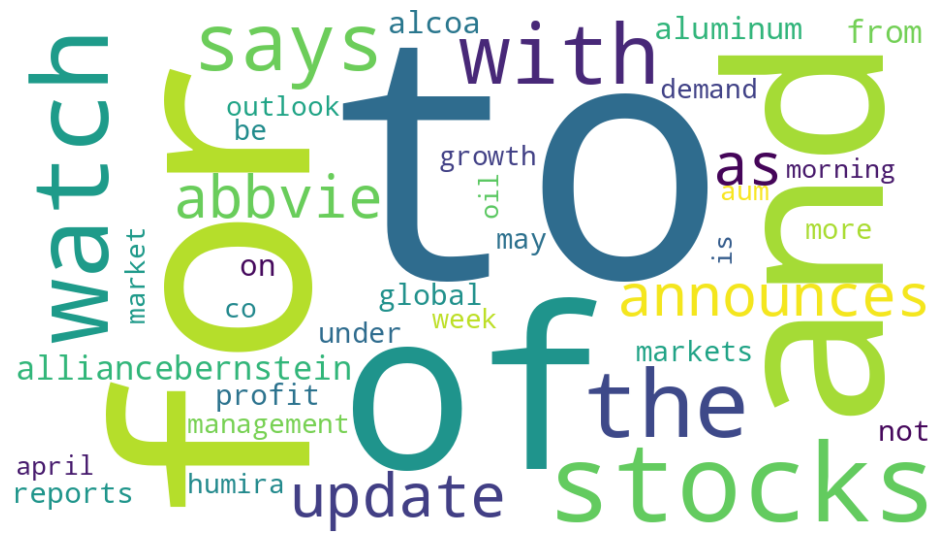

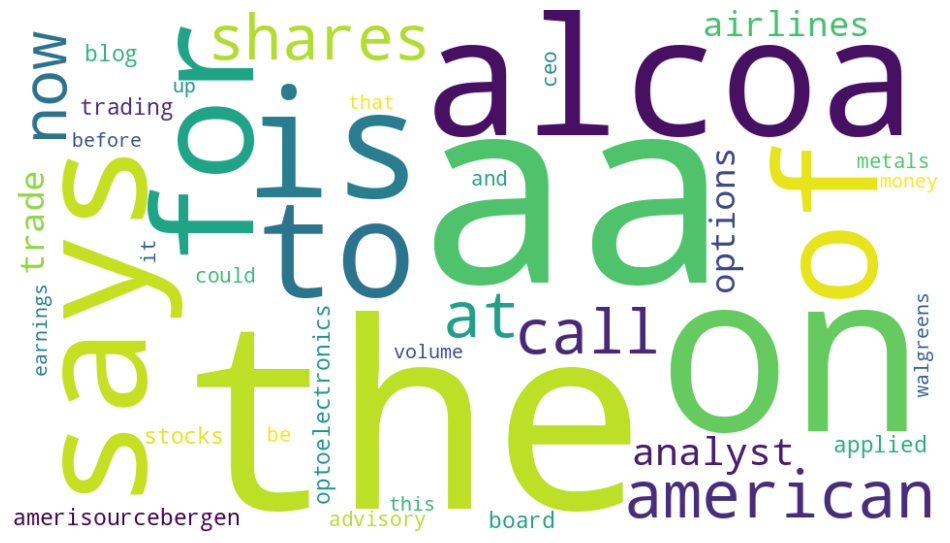

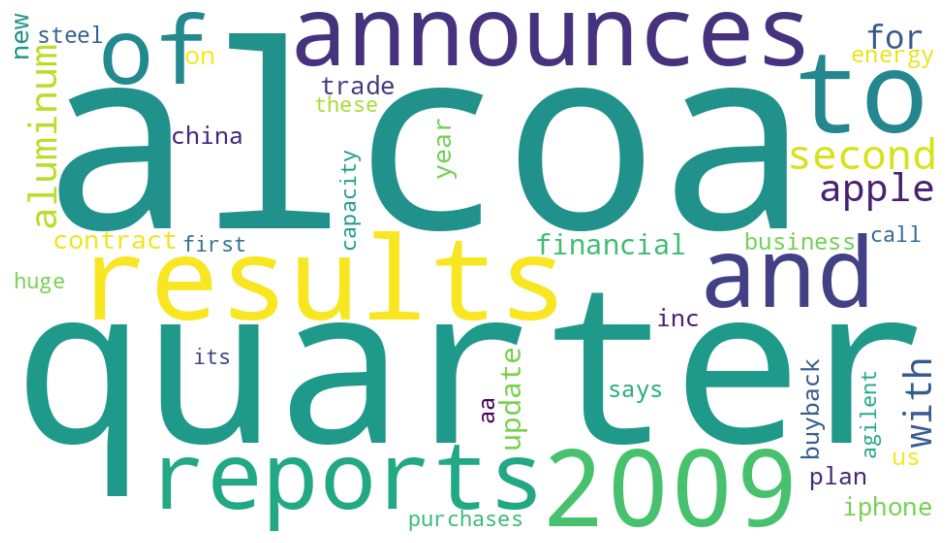

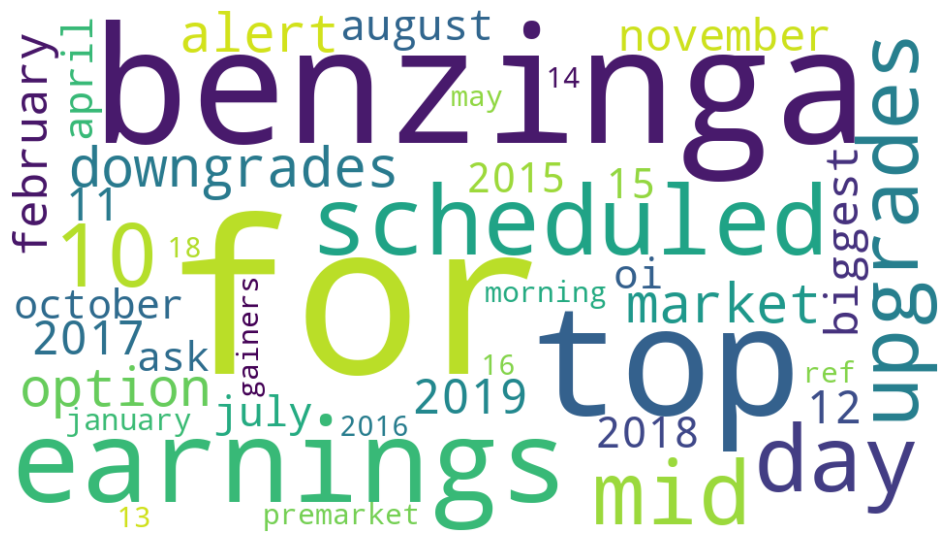

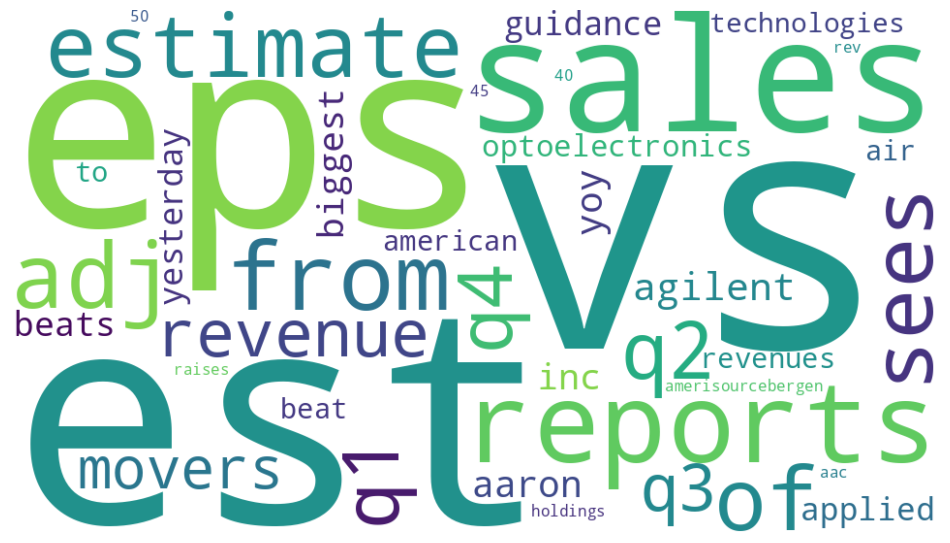

In [12]:
# import required libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics (model, features, no_top_words = 40):
    for topic, words in enumerate (model.components_):
        size = {}
        largest = words.argsort ()[::-1]  # invert sort order
        for i in range (0, no_top_words):
            size [features [largest [i]]] = abs (words [largest [i]])
        wc = WordCloud (background_color = "white", max_words = 100,
                       width = 960, height = 540)
        wc.generate_from_frequencies (size)
        plt.figure (figsize = (12, 12))
        plt.imshow (wc, interpolation = 'bilinear')
        plt.axis ('off')
        
# compare NMF and LDA model
wordcloud_topics (nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())
wordcloud_topics (lda_para_model, count_para_vectorizer.get_feature_names_out ())

**Building a neural network using Pytorch**

In [13]:
# import required libraries
import torch
import torch.nn as nn

x = [[2, 5], [7, 9], [4, 8], [6, 9]]
y = [[4], [9], [12], [17]]

X = torch.tensor (x).float ()
Y = torch.tensor (y).float ()

device = 'cuda' if torch.cuda.is_available () else 'cpu'
X = X.to(device)
Y = Y.to(device)

class MyNeuralNet (nn.Module):
    def __init__(self):
        super().__init__()
        self.input_to_hidden_layer = nn.Linear (2, 8)
        self.hidden_layer_activation = nn.ReLU()
        self.hidden_to_output_layer = nn.Linear (8, 1)
    def forward (self, x):
        x = self.input_to_hidden_layer (x)
        x = self.hidden_layer_activation (x)
        x = self.hidden_to_output_layer (x)
        return x
    
mynet = MyNeuralNet().to(device)
loss_func = nn.MSELoss()

_Y = mynet(X)
loss_value = loss_func (_Y, Y)
print (loss_value)

tensor(229.5637, device='cuda:0', grad_fn=<MseLossBackward0>)


Text(0, 0.5, 'loss value')

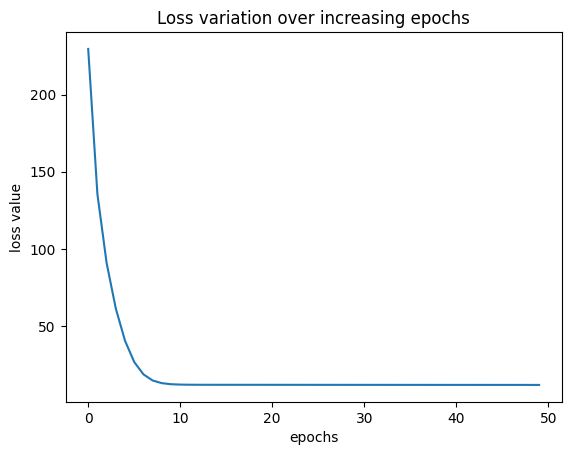

In [14]:
from torch.optim import SGD
import matplotlib.pyplot as plt
%matplotlib inline

opt = SGD (mynet.parameters(), lr = 0.001)

loss_history = []
for _ in range(50):
    opt.zero_grad()
    loss_value = loss_func (mynet (X), Y)
    loss_value.backward ()
    opt.step ()
    loss_history.append (loss_value.item())
    
plt.plot(loss_history)
plt.title ('Loss variation over increasing epochs')
plt.xlabel ('epochs')
plt.ylabel ('loss value')

**Resnet block architecture**

In [15]:
import torch
from torch import nn

class ResLayer (nn.Module):
    def __init__ (self, ni, no, kernel_size, stride=1):
        super (ResLayer, self).__init__()
        padding = kernel_size - 2
        self_conv = nn.Sequential (
        nn.Conv2d (ni, no, kernel_size, stride,
                  padding = padding),
        nn.ReLU ())
        
    def forward (self, x):
        return self.conv (x) + x

In [16]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
!pip install torch_summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.vgg16(pretrained=True).to(device)
summary(model, torch.zeros(1,3,224,224))

  Obtaining dependency information for torch_summary from https://files.pythonhosted.org/packages/ca/db/93d18c84f73b214acfa4d18051d6f4263eee3e044c408928e8abe941a22c/torch_summary-1.4.5-py3-none-any.whl.metadata


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 315MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [17]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Fine-tuning BERT model**

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/in_domain_train.tsv --output "in_domain_train.tsv"
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  2379k      0 --:--:-- --:--:-- --:--:-- 2393k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0   158k      0 --:--:-- --:--:-- --:--:--  158k


In [20]:
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [21]:
df.sample(15)

sentence_source  label label_notes  \
5284            b_82      1         NaN   
7732            ad03      1         NaN   
666             bc01      1         NaN   
660             bc01      1         NaN   
1421            r-67      0           *   
446             bc01      0           *   
4292            ks08      1         NaN   
4889            ks08      0           *   
6685            m_02      1         NaN   
5481            b_73      1         NaN   
1122            r-67      1         NaN   
3049            l-93      0           *   
6097            c_13      1         NaN   
3363            l-93      0           *   
7342           sks13      1         NaN   

                                               sentence  
5284       how certain that the mets will win are you ?  
7732      emily showed benjamin himself in the mirror .  
666   sue put the books on the table and the records...  
660                we have someone in the living room .  
1421  the university 's students are intelligent and...  
446                      john thinks what mary bought .  
4292              the dentist is eager to examine pat .  
4889             the person stood on my foot is heavy .  
6685                 did frank buy something for jane .  
5481  what her mother wants her to be is such a fine...  
1122  i found delicious some fruit which i picked up...  
3049                     ellen told for helen to come .  
6097                               john left his wife .  
3363                     there lay a dog in the comer .  
7342                         they surrounded the fort .

In [22]:
# Creating sentence, label lists and adding Bert tokens
sentences = df.sentence_source.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence_source + " [SEP]" for sentence_source in sentences]
labels = df.label.values

# Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'g', '##j', '##0', '##4', '[SEP]']


In [23]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
# Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state = 2018, test_size = 0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state = 2018, test_size = 0.1)

# Converting all the data into torch tensors
# Torch tensors are the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Selecting a Batch Size and Creating and Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size = batch_size)

In [24]:
# BERT Model Configuration, initializing a BERT bert-base-uncased style configuration
# Transformer Installation
try:
    import transformers
except:
    print("Installing transformers")
    !pip -qq install transformers
    
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [25]:
# Loading the Hugging Face Bert uncased base model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model = nn.DataParallel(model)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [26]:
# Optimizer Grouped Parameters
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102
# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have 'gamma' or 'beta' parameters, only 'bias' terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

# Separate the 'weight' parameters from the 'bias' parameters.
# - For the 'weight' parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the 'bias' parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Displaying a sample of the parameter_optimizer:  layer 3
layer_parameters = [p for n, p in model.named_parameters() if 'layer.3' in n]

# Displaying names of parameters for which weight decay is not applied
no_decay

['bias', 'LayerNorm.weight']

In [27]:
# Displaying the list of the two dictionaries
small_sample = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.1},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.0}
]

for i, group in enumerate(small_sample):
    print(f"Group {i+1}:")
    print(f"Weight decay rate: {group['weight_decay_rate']}")
    for j, param in enumerate(group['params']):
        print(f"Parameter {j+1}: {param}")
     

Group 1:
Weight decay rate: 0.1
Parameter 1: Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       device='cuda:0', requires_grad=True)
Parameter 2: Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
          4.3435e-04, -2.6949e-

In [28]:
# the hyperparameters for the training loop\
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = torch.optim.AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [29]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
# the training loop
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Training
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs['loss']
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Validation

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Tracking variables
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch: 100%|██████████| 4/4 [05:48<00:00, 87.13s/it]


Train loss: 0.6002907823477543
Validation Accuracy: 0.6925154320987654


**Training evaluation**

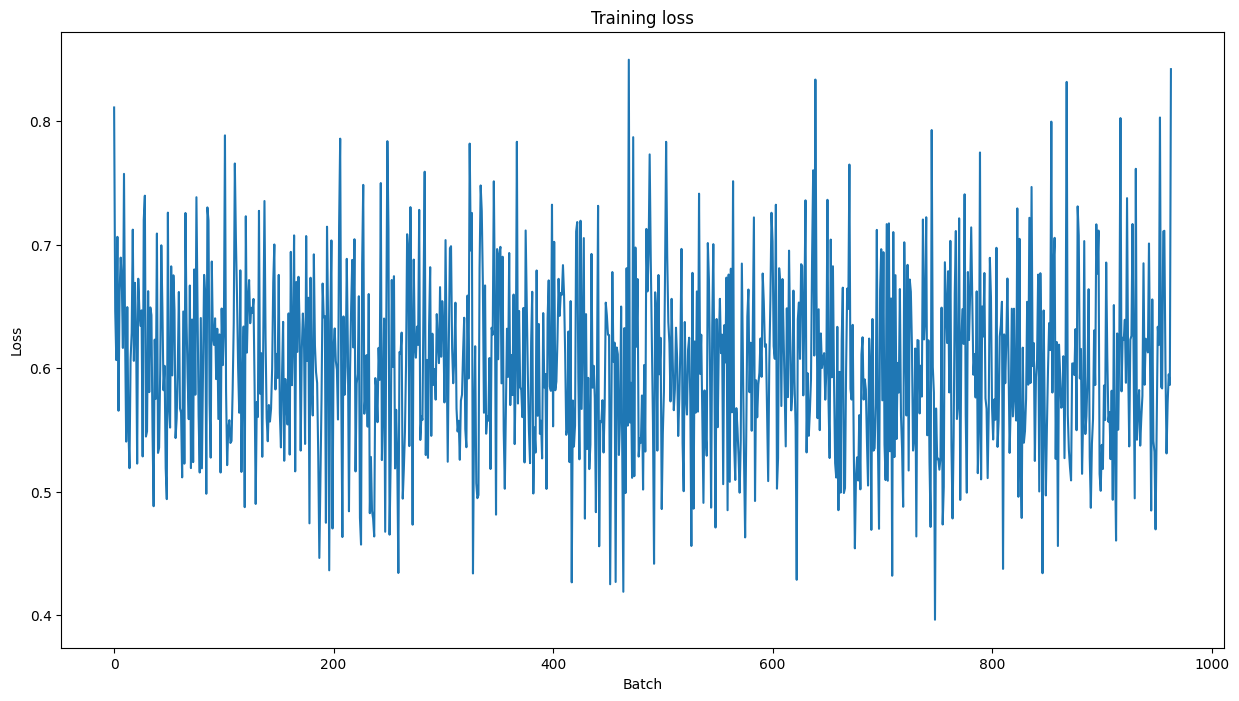

In [31]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Predicting and evaluating using the holdout dataset**

In [32]:
#loading the holdout dataset
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [33]:
df.shape

(516, 4)

In [34]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [35]:
#Softmax logits
import numpy as np

def softmax(logits):
    e = np.exp(logits)
    return e / np.sum(e)

In [36]:
# Put model in evaluation mode
model.eval()

# Tracking variables
raw_predictions, predicted_classes, true_labels = [], [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = outputs['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Convert input_ids back to words
  b_input_ids = b_input_ids.to('cpu').numpy()
  batch_sentences = [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in b_input_ids]

  # Apply softmax function to convert logits into probabilities
  probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

  # The predicted class is the one with the highest probability
  batch_predictions = np.argmax(probabilities, axis=1)

  # Print the sentences and the corresponding predictions for this batch
  for i, sentence in enumerate(batch_sentences):
    print(f"Sentence: {sentence}")
    print(f"Prediction: {logits[i]}")
    print(f"Sofmax probabilities", softmax(logits[i]))
    print(f"Prediction: {batch_predictions[i]}")
    print(f"True label: {label_ids[i]}")

  # Store raw predictions, predicted classes and true labels
  raw_predictions.append(logits)
  predicted_classes.append(batch_predictions)
  true_labels.append(label_ids)

Sentence: somebody just left - guess who.
Prediction: [-0.17789245  0.5635753 ]
Sofmax probabilities [0.32268324 0.6773167 ]
Prediction: 1
True label: 1
Sentence: they claimed they had settled on something, but it wasn't clear what they had settled on.
Prediction: [-0.34331724  0.6080759 ]
Sofmax probabilities [0.27860472 0.72139525]
Prediction: 1
True label: 1
Sentence: if sam was going, sally would know where.
Prediction: [-0.13518754  0.5397003 ]
Sofmax probabilities [0.33740324 0.66259676]
Prediction: 1
True label: 1
Sentence: they're going to serve the guests something, but it's unclear what.
Prediction: [-0.17863171  0.5418924 ]
Sofmax probabilities [0.32727757 0.6727224 ]
Prediction: 1
True label: 1
Sentence: she's reading. i can't imagine what.
Prediction: [-0.23261793  0.6345994 ]
Sofmax probabilities [0.29583368 0.7041663 ]
Prediction: 1
True label: 1
Sentence: john said joan saw someone from her graduating class.
Prediction: [-0.17369604  0.53497744]
Sofmax probabilities [0.